### Load Data, drop empty Txt and Settings
----

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
from gensim.models import KeyedVectors

In [8]:
## SETTINGS

# active models
SET_NN_active = False

SET_track_scores = True
SET_name_outputfile = "performance_280323.csv"
PATH_glove_model = "models/glove_300.model"

SET_datapath = "data_pp.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,u created request scholarlyarticles awaiting c...,1,6
1,looking lgbt profession category point get beh...,1,17
2,new york city regulation regarding apparently ...,0,12
3,thank speedy rollback would believe first time...,1,16
4,want talk stuff perfectly willing refer commen...,0,53


### Word Embedding

----

#### Glove Vectorizer

In [9]:
import numpy as np
# np.seterr(invalid='ignore')

def get_embedding(series, model, tokenizer):
    embedding_matrix = []

    for text in series.to_list():
        text_vec = np.zeros(model.vector_size)
        number_of_vectors = 0

        tokens = tokenizer.tokenize(text)

        for token in tokens:
            number_of_vectors += 1

            if token in model.key_to_index:
                text_vec = text_vec + model[token]

        embedding_matrix.append( text_vec / number_of_vectors)

    return np.array(embedding_matrix)

In [10]:
if not os.path.isdir("models/"):
    os.mkdir("models")

if not os.path.isfile(PATH_glove_model):
    import gensim.downloader as api

    glove_model = api.load("glove-wiki-gigaword-300")
    glove_model.save(PATH_glove_model)

In [11]:
model_glove = KeyedVectors.load(PATH_glove_model)

In [12]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

X = get_embedding(df.comment_text, model_glove, tokenizer)
y = df.toxic.values

### Split Data for Models
----

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (240368, 300)
X_test shape: (60092, 300)
y_train shape: (240368,)
y_test shape: (60092,)


### Train Models and get Scores

----

#### Try... Neural Network

In [15]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [16]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report["macro avg"]["recall"]
        precision = report["macro avg"]["precision"]
        f1_score = report["macro avg"]["f1-score"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall', 'F1-Score']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'Glove', 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

#### Naive Bayes:

--------------------Training Performance---------------------
0.650373593822805


D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packa

              precision    recall  f1-score   support

           0       0.65      1.00      0.79    156329
           1       0.00      0.00      0.00     84039

    accuracy                           0.65    240368
   macro avg       0.33      0.50      0.39    240368
weighted avg       0.42      0.65      0.51    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.650369433535246
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     39082
           1       0.00      0.00      0.00     21010

    accuracy                           0.65     60092
   macro avg       0.33      0.50      0.39     60092
weighted avg       0.42      0.65      0.51     60092



D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


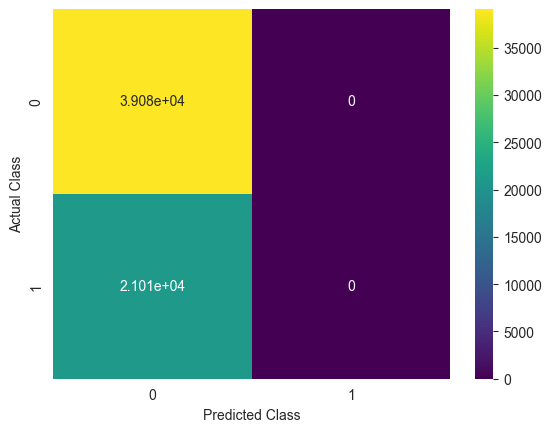

D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\_4semester\nlp-p02_2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression:

--------------------Training Performance---------------------
0.7134477135059575
              precision    recall  f1-score   support

           0       0.71      0.95      0.81    156329
           1       0.74      0.28      0.40     84039

    accuracy                           0.71    240368
   macro avg       0.73      0.61      0.61    240368
weighted avg       0.72      0.71      0.67    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7113093257005925
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     39082
           1       0.74      0.27      0.40     21010

    accuracy                           0.71     60092
   macro avg       0.72      0.61      0.60     60092
weighted avg       0.72      0.71      0.67     60092



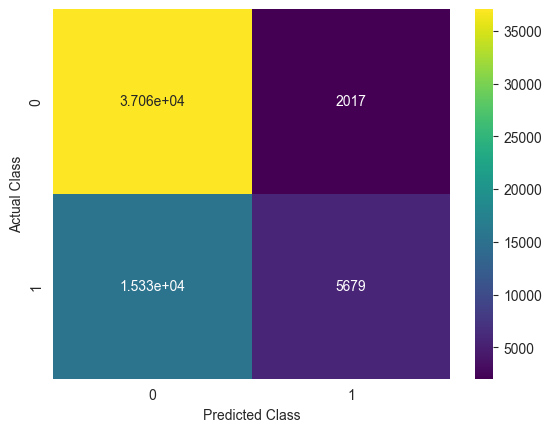

In [18]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.7330260267589696
              precision    recall  f1-score   support

           0       0.72      0.97      0.83    156329
           1       0.85      0.29      0.43     84039

    accuracy                           0.73    240368
   macro avg       0.79      0.63      0.63    240368
weighted avg       0.76      0.73      0.69    240368

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.704503095253944
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     39082
           1       0.74      0.24      0.36     21010

    accuracy                           0.70     60092
   macro avg       0.72      0.60      0.58     60092
weighted avg       0.71      0.70      0.65     60092



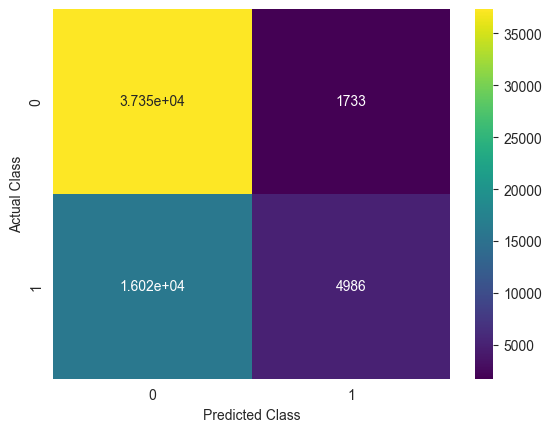

In [19]:
model = RandomForestClassifier(n_estimators=100,max_depth=10,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [20]:
print("finished")

finished
